Test evaluation functions

In [11]:
%matplotlib inline
import os
import sys
import json
from glob import glob
from timeit import default_timer as timer

import tabulate
from tqdm import tqdm
import numpy as np
import pandas as pd
import h5py
import scipy
import scipy.interpolate
import scipy.stats
import torch
import dill
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib.animation as animation

import utility as util
from collect.visualize.trajectron import render_roads
from collect.predict.trajectron import generate_vehicle_latents

from helper import load_model, prediction_output_to_trajectories
from model.dataset import get_timesteps_data
from model.model_utils import ModeKeys

pd.set_option('io.hdf.default_format','table')
AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

Search datasets

In [2]:
search_datasets = False
dataset_dir = "../../../.."
glob(f"{ dataset_dir }/**/*.pkl") if search_datasets else []

[]

Load a dataset

In [3]:
dataset_0 = util.AttrDict(
    test_set_path='../../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset with bitmap matching NuScenes")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset_4 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3_0_1_dataset/carla_test_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        v2_bitmap=True)

dataset_5 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1_dataset/v3-1_split1_test.pkl",
        name='v3-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_6 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1-1_dataset/v3-1-1_split1_test.pkl",
        name='v3-1-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset = dataset_6
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.


Search models

- 20210621 one model trained on NuScenes.
- 20210801 have models trained from v3-1-1 (train set has 200 scenes). Compare MapV2, MapV3.
- 20210802 have models trained from v3-1-1. MapV5 squeezes map encoding to size 32 using FC.
- 20210803 have models trained from v3-1-1. Compare map, mapV4. MapV4 with multi K values. MapV4 does not apply FC. May have size 100 or 150.
- 20210804 have models trained from v3-1 (train set has 300 scenes). Compare map with mapV4.
- 20210812 have models trained from v3-1-1 rebalanced. Models are trained 20 epochs.
- 20210815 have models trained from v3-1-1 rebalanced. Models are trained 40 epochs.
- 20210816 have models trained from v3-1-2 (train set has 600 scenes) rebalanced.

In [4]:
search_dirs = False
[x for x in glob('../models/*')] if search_dirs else None

In [5]:
search_models = False
[x[0] for x in os.walk('../models')] if search_models else None

Load a model

In [6]:
model_1 = util.AttrDict(
        path='../models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='../models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='../models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='../models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='../models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_9 = util.AttrDict(
        path='../models/models_19_Jul_2021_21_09_20_carla_v3_0_1_base_dist_ph6',
        desc="Base model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_10 = util.AttrDict(
        path='../models/models_19_Jul_2021_22_45_29_carla_v3_0_1_base_distmap_ph6',
        desc="Base +Map model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_11 = util.AttrDict(
        path='../models/models_20_Jul_2021_11_48_11_carla_v3_0_1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8 "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_12 = util.AttrDict(
        path='../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8, K=25 "
             "(trained on carla v3-1 dataset)")

model_13 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_37_17_carla_v3-1_base_distmap_K20_ph8',
        desc="Base +Map model with heading fix, PH=8, K=20 "
             "(trained on carla v3-1 dataset)")

model_14 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_38_46_carla_v3-1_base_distmap_K15_ph8',
        desc="Base +Map model with heading fix, PH=8, K=15 "
             "(trained on carla v3-1 dataset)")

model_15 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_38_20_carla_v3-1_base_distmap_K10_ph8',
        desc="Base +Map model with heading fix, PH=8, K=10 "
             "(trained on carla v3-1 dataset)")

model_16 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_39_52_carla_v3-1_base_distmap_K5_ph8',
        desc="Base +Map model with heading fix, PH=8, K=5 "
             "(trained on carla v3-1 dataset)")

model_17 = util.AttrDict(
        path='../models/20210801/models_01_Aug_2021_20_02_57_carla_v3-1-1_base_distmapV3_ph8',
        desc="Base +MapV2 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_18 = util.AttrDict(
        path='../models/20210802/models_02_Aug_2021_19_29_27_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_19 = util.AttrDict(
        path='../models/20210803/models_03_Aug_2021_13_42_51_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_20 = util.AttrDict(
        path='../models/20210804/models_04_Aug_2021_19_14_01_carla_v3-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on carla v3-1 dataset)")

model_21 = util.AttrDict(
        path='../models/20210803/models_05_Aug_2021_21_29_38_carla_v3-1-1_base_distmapV4_K5_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=5 "
             "(trained on smaller carla v3-1-1 dataset)")

model_22 = util.AttrDict(
        path='../models/20210816/models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8',
        desc="??? model "
             "(trained on carla v3-1-2 dataset w/ rebalancing)")

model = model_22
eval_stg, hyp = load_model(model.path, eval_env, ts=20)#, device='cuda')
print(model.desc)


Loading from ../models/20210816/models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8/model_registrar-20.pt
Loaded!

??? model (trained on carla v3-1-2 dataset w/ rebalancing)


## Combining forecast and map

In [7]:
def produce_predictions(ax, scene, timestep, predictconfig, eval_stg, hyp):
    t = timestep
    max_hl = hyp['maximum_history_length']
    timesteps = np.array([t])
    with torch.no_grad():
        predictions = eval_stg.predict(scene,
                timesteps, predictconfig.ph, num_samples=predictconfig.num_samples,
                    z_mode=predictconfig.z_mode,
                    gmm_mode=predictconfig.gmm_mode,
                    full_dist=predictconfig.full_dist,
                    all_z_sep=predictconfig.all_z_sep)

    prediction_dict, histories_dict, futures_dict = \
        prediction_output_to_trajectories(
            predictions, dt=scene.dt, max_h=max_hl, ph=predictconfig.ph, map=None)

    v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
    render_roads(ax, scene)

    for idx, node in enumerate(v_nodes):
        player_future = futures_dict[t][node]
        player_past = histories_dict[t][node]
        player_predict = prediction_dict[t][node]

        ax.plot(player_future[:,0], player_future[:,1],
                    marker='s', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
        ax.plot(player_past[:,0], player_past[:,1],
                    marker='d', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
        if getattr(predictconfig, 'show_predictions', True):
            for row in player_predict[0]:
                ax.plot(row[:,0], row[:,1],
                        marker='o', color=AGENT_COLORS[idx % NCOLORS],
                        linewidth=1, markersize=4, alpha=getattr(predictconfig, 'alpha', 0.1))

In [8]:
num_samples = 2000
ph = 8

def get_scene_2():
    """example where many models are not multi-modal in v3-1-1 dataset"""
    idx, t = 28, 7
    return eval_scenes[idx], t

def get_scene_3():
    """example of vehicle slowly turning right v3-1-1 dataset"""
    idx, t = 30, 17
    return eval_scenes[idx], t

scene, timestep = get_scene_2()

Used for most types of visualization, and to compute average FDE score

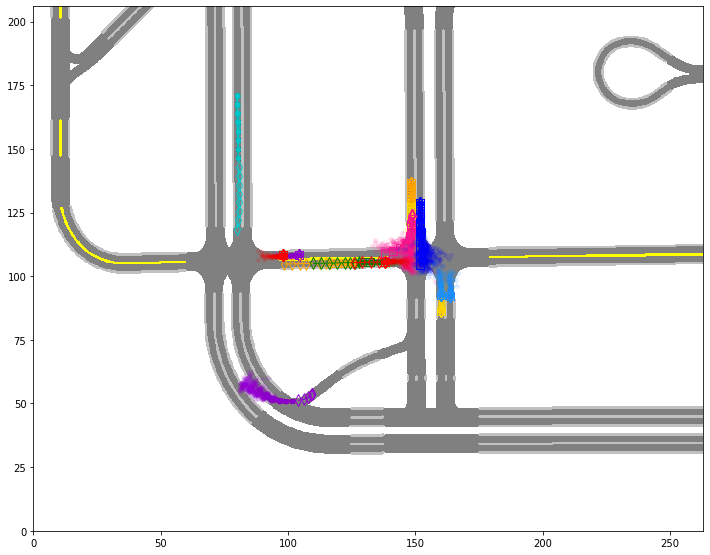

In [9]:
predictconfig = util.AttrDict(ph=8, num_samples=100, z_mode=False, gmm_mode=False,
        full_dist=False, all_z_sep=False, show_predictions=True)

fig, ax = plt.subplots(figsize=(12,15))
produce_predictions(ax, scene, timestep, predictconfig, eval_stg, hyp)

extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = False
if should_zoom_in:
    zoom = np.array([70, 70])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
None

This is used to compute the FDE Most Likely metric. Sample the GMM's mode for the most likely latent.

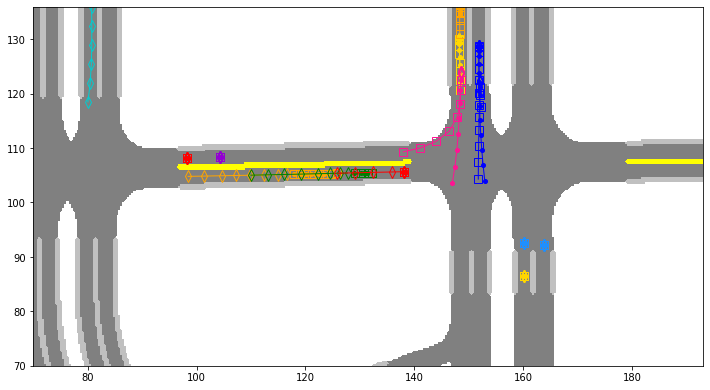

In [10]:
predictconfig = util.AttrDict(ph=8, num_samples=1, z_mode=True, gmm_mode=True,
        full_dist=False, all_z_sep=False, show_predictions=True, alpha=1)

fig, ax = plt.subplots(figsize=(12,15))
produce_predictions(ax, scene, timestep, predictconfig, eval_stg, hyp)

extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = True
if should_zoom_in:
    zoom = np.array([70, 70])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
None

Sample one prediction per latent value. The predictions are sample from GMM's mode. Attribute `num_samples` ignored.

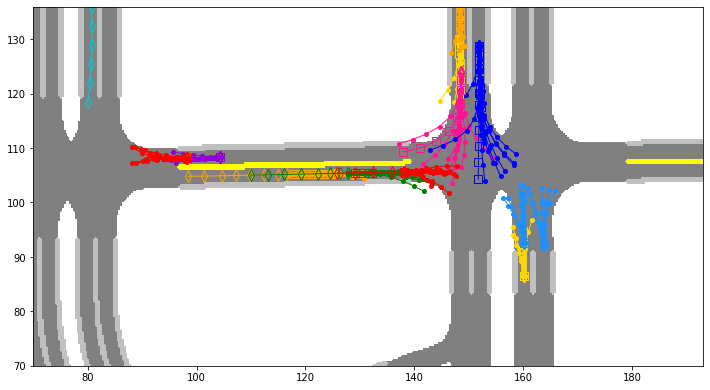

In [11]:
predictconfig = util.AttrDict(ph=8, num_samples=1, z_mode=False, gmm_mode=True,
        full_dist=False, all_z_sep=True, alpha=1)

fig, ax = plt.subplots(figsize=(12,15))
produce_predictions(ax, scene, timestep, predictconfig, eval_stg, hyp)

extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = True
if should_zoom_in:
    zoom = np.array([70, 70])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
None

## Test Evaluation Metrics

In [12]:
############################
# Bag-of-N (BoN) FDE metrics
############################

def compute_min_FDE(predict, future):
    return np.min(np.linalg.norm(predict[...,-1,:] - future[-1], axis=-1))

def compute_min_ADE(predict, future):
    mean_ades = np.mean(np.linalg.norm(predict - future, axis=-1), axis=-1)
    return np.min(mean_ades)

def evaluate_scene_BoN(scene, ph, eval_stg, hyp, n_predictions=20, min_fde=True, min_ade=True):
    predictconfig = util.AttrDict(ph=ph, num_samples=n_predictions, z_mode=False, gmm_mode=False,
            full_dist=False, all_z_sep=False)
    max_hl = hyp['maximum_history_length']
    with torch.no_grad():
        predictions = eval_stg.predict(scene,
                np.arange(scene.timesteps), predictconfig.ph,
                num_samples=predictconfig.num_samples,
                min_future_timesteps=predictconfig.ph,
                z_mode=predictconfig.z_mode,
                gmm_mode=predictconfig.gmm_mode,
                full_dist=predictconfig.full_dist,
                all_z_sep=predictconfig.all_z_sep)

    prediction_dict, histories_dict, futures_dict = \
        prediction_output_to_trajectories(
            predictions, dt=scene.dt, max_h=max_hl, ph=predictconfig.ph, map=None)

    batch_metrics = {'min_ade': list(), 'min_fde': list()}
    for t in prediction_dict.keys():
        for node in prediction_dict[t].keys():
            if min_ade:
                batch_metrics['min_ade'].append(compute_min_ADE(prediction_dict[t][node], futures_dict[t][node]))
            if min_fde:
                batch_metrics['min_fde'].append(compute_min_FDE(prediction_dict[t][node], futures_dict[t][node]))
    return batch_metrics

def evaluate_BoN(env, ph, eval_stg, hyp, n_predictions=20, min_fde=True, min_ade=True):
    batch_metrics = {'min_ade': list(), 'min_fde': list()}
    prefix = f"Evaluate Bo{n_predictions} (ph = {ph}): "
    for scene in tqdm(env.scenes, desc=prefix, dynamic_ncols=True, leave=True):
        _batch_metrics = evaluate_scene_BoN(scene, ph, eval_stg, hyp,
                n_predictions=n_predictions, min_fde=min_fde, min_ade=min_ade)
        batch_metrics['min_ade'].extend(_batch_metrics['min_ade'])
        batch_metrics['min_fde'].extend(_batch_metrics['min_fde'])
    return batch_metrics

###############
# Other metrics
###############

def make_interpolate_map(scene):
    map =  scene.map['VEHICLE']
    obs_map = 1 - np.max(map.data[..., :, :, :], axis=-3) / 255
    interp_obs_map = scipy.interpolate.RectBivariateSpline(
            range(obs_map.shape[0]),
            range(obs_map.shape[1]),
            obs_map, kx=1, ky=1)
    return interp_obs_map

def compute_num_offroad_viols(interp_map, scene_map, predicted_trajs):
    """Count the number of predicted trajectories that go off the road.
    Note this does not count trajectories that go over road/lane dividers.
    
    Parameters
    ==========
    interp_map : scipy.interpolate.RectBivariateSpline
        Interpolation to get road obstacle indicator value from predicted points.
    scene_map : trajectron.environment.GeometricMap
        Map transform the predicted points to map coordinates.
    predicted_trajs : ndarray
        Predicted trajectories of shape (number of predictions, number of timesteps, 2).
    
    Returns
    =======
    int
        A value between [0, number of predictions].
    """
    old_shape = predicted_trajs.shape
    pred_trajs_map = scene_map.to_map_points(predicted_trajs.reshape((-1, 2)))
    traj_values = interp_map(pred_trajs_map[:, 0], pred_trajs_map[:, 1], grid=False)
    # traj_values has shape (1, num_samples, ph).
    traj_values = traj_values.reshape((old_shape[0], old_shape[1], old_shape[2]))
    # num_viol_trajs is an integer in [0, num_samples].
    return np.sum(traj_values.max(axis=2) > 0, dtype=float)

def compute_kde_nll(predicted_trajs, gt_traj):
    kde_ll = 0.
    log_pdf_lower_bound = -20
    num_timesteps = gt_traj.shape[0]
    num_batches = predicted_trajs.shape[0]
    for batch_num in range(num_batches):
        for timestep in range(num_timesteps):
            try:
                kde = scipy.stats.gaussian_kde(predicted_trajs[batch_num, :, timestep].T)
                pdf = kde.logpdf(gt_traj[timestep].T)
                pdf = np.clip(kde.logpdf(gt_traj[timestep].T), a_min=log_pdf_lower_bound, a_max=None)[0]
                kde_ll += pdf / (num_timesteps * num_batches)
            except np.linalg.LinAlgError:
                kde_ll = np.nan

    return -kde_ll

def compute_ade(predicted_trajs, gt_traj):
    error = np.linalg.norm(predicted_trajs - gt_traj, axis=-1)
    ade = np.mean(error, axis=-1)
    return ade.flatten()

def compute_fde(predicted_trajs, gt_traj):
    final_error = np.linalg.norm(predicted_trajs[:, :, -1] - gt_traj[-1], axis=-1)
    return final_error.flatten()

########################
# Most Likely Evaluation
########################

def evaluate_scene_most_likely(scene, ph, eval_stg, hyp,
            ade=True, fde=True):
    predictconfig = util.AttrDict(ph=ph, num_samples=1,
            z_mode=True, gmm_mode=True, full_dist=False, all_z_sep=False)
    max_hl = hyp['maximum_history_length']
    with torch.no_grad():
        predictions = eval_stg.predict(scene,
                np.arange(scene.timesteps), predictconfig.ph,
                num_samples=predictconfig.num_samples,
                min_future_timesteps=predictconfig.ph,
                z_mode=predictconfig.z_mode,
                gmm_mode=predictconfig.gmm_mode,
                full_dist=predictconfig.full_dist,
                all_z_sep=predictconfig.all_z_sep)

    prediction_dict, histories_dict, futures_dict = \
            prediction_output_to_trajectories(
                predictions, dt=scene.dt, max_h=max_hl, ph=predictconfig.ph, map=None)

    interp_map = make_interpolate_map(scene)
    map =  scene.map['VEHICLE']
    batch_metrics = {'ade': list(), 'fde': list()}
    for t in prediction_dict.keys():
        for node in prediction_dict[t].keys():
            if ade:
                batch_metrics['ade'].extend(
                        compute_ade(prediction_dict[t][node], futures_dict[t][node]) )
            if fde:
                batch_metrics['fde'].extend(
                        compute_fde(prediction_dict[t][node], futures_dict[t][node]) )
    return batch_metrics

def evaluate_most_likely(env, ph, eval_stg, hyp,
        ade=True, fde=True):
    batch_metrics = {'ade': list(), 'fde': list()}
    prefix = f"Evaluate Most Likely (ph = {ph}): "
    for scene in tqdm(env.scenes, desc=prefix, dynamic_ncols=True, leave=True):
        _batch_metrics = evaluate_scene_most_likely(scene, ph, eval_stg, hyp,
                ade=ade, fde=fde)
        batch_metrics['ade'].extend(_batch_metrics['ade'])
        batch_metrics['fde'].extend(_batch_metrics['fde'])
    return batch_metrics

#################
# Full Evaluation
#################

def evaluate_scene_full(scene, ph, eval_stg, hyp,
            ade=True, fde=True, kde=True, offroad_viols=True):
    num_samples = 2000
    predictconfig = util.AttrDict(ph=ph, num_samples=num_samples,
            z_mode=False, gmm_mode=False, full_dist=False, all_z_sep=False)
    max_hl = hyp['maximum_history_length']
    with torch.no_grad():
        predictions = eval_stg.predict(scene,
                np.arange(scene.timesteps), predictconfig.ph,
                num_samples=predictconfig.num_samples,
                min_future_timesteps=predictconfig.ph,
                z_mode=predictconfig.z_mode,
                gmm_mode=predictconfig.gmm_mode,
                full_dist=predictconfig.full_dist,
                all_z_sep=predictconfig.all_z_sep)

    prediction_dict, histories_dict, futures_dict = \
            prediction_output_to_trajectories(
                predictions, dt=scene.dt, max_h=max_hl, ph=predictconfig.ph, map=None)

    interp_map = make_interpolate_map(scene)
    map =  scene.map['VEHICLE']
    batch_metrics = {'ade': list(), 'fde': list(), 'kde': list(), 'offroad_viols': list()}
    
    for t in prediction_dict.keys():
        for node in prediction_dict[t].keys():
            if ade:
                batch_metrics['ade'].extend(
                        compute_ade(prediction_dict[t][node], futures_dict[t][node]) )
            if fde:
                batch_metrics['fde'].extend(
                        compute_fde(prediction_dict[t][node], futures_dict[t][node]) )
            if offroad_viols:
                batch_metrics['offroad_viols'].extend(
                        [ compute_num_offroad_viols(interp_map, map, prediction_dict[t][node]) / float(num_samples) ])
            if kde:
                batch_metrics['kde'].extend(
                        [ compute_kde_nll(prediction_dict[t][node], futures_dict[t][node]) ])
    return batch_metrics

def evaluate_full(env, ph, eval_stg, hyp,
        ade=True, fde=True, kde=True, offroad_viols=True):
    batch_metrics = {'ade': list(), 'fde': list(), 'kde': list(), 'offroad_viols': list()}
    prefix = f"Evaluate Full (ph = {ph}): "
    for scene in tqdm(env.scenes, desc=prefix, dynamic_ncols=True, leave=True):
        _batch_metrics = evaluate_scene_full(scene, ph, eval_stg, hyp,
                ade=ade, fde=fde, kde=kde, offroad_viols=offroad_viols)
        batch_metrics['ade'].extend(_batch_metrics['ade'])
        batch_metrics['fde'].extend(_batch_metrics['fde'])
        batch_metrics['kde'].extend(_batch_metrics['kde'])
        batch_metrics['offroad_viols'].extend(_batch_metrics['offroad_viols'])
    return batch_metrics

In [14]:
dataset_id = '/'.join(model.path.split('/')[-2:] + ['BoN'])

with pd.HDFStore('test.h5', 'a') as s:
    for ph in [2,4,6,8]:
        batch_metrics = evaluate_BoN(eval_env, ph, eval_stg, hyp)
        df = pd.DataFrame(batch_metrics)
        df['ph'] = ph
        s.put(dataset_id, df, format='t', append=True, data_columns=True)

Evaluate Bo20 (ph = 2): 100%|██████████| 60/60 [01:13<00:00,  1.22s/it]
/home/fireofearth/.local/miniconda3/envs/trajectron-cplex/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '20210816'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/fireofearth/.local/miniconda3/envs/trajectron-cplex/lib/python3.6/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
Evaluate Bo20 (ph = 8): 100%|██████████| 60/60 [00:56<00:00,  1.07it/s]


In [13]:
dataset_id = '/'.join(model.path.split('/')[-2:] + ['BoN'])
with pd.HDFStore('test.h5', 'r') as s:
    print(*s.keys())
    print("Columns are", *s[dataset_id].columns)
    print(s[dataset_id])

/20210816/models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8/BoN /20210816/models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8/ML
Columns are min_ade min_fde ph
        min_ade   min_fde  ph
0      0.005277  0.003977   2
1      0.048575  0.049192   2
2      0.003805  0.003530   2
3      0.012061  0.009768   2
4      0.006130  0.002093   2
...         ...       ...  ..
14050  0.790948  1.116315   8
14051  0.004994  0.005436   8
14052  0.004728  0.005640   8
14053  0.008820  0.014377   8
14054  0.002915  0.002830   8

[67445 rows x 3 columns]


Bag-of-20 FDE is 0.5554576641166195


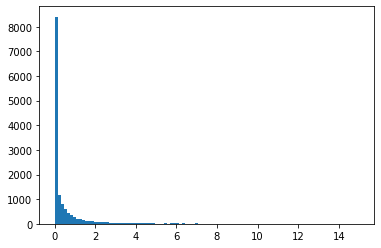

In [14]:
dataset_id = '/'.join(model.path.split('/')[-2:] + ['BoN'])
with pd.HDFStore('test.h5', 'r') as s:
    df = s[dataset_id]
    df = df[df['ph'] == 8]
    print(f"Bag-of-20 FDE is {np.mean(df['min_fde'])}")
    plt.hist(df['min_fde'], bins=100)

In [14]:
dataset_id = '/'.join(model.path.split('/')[-2:] + ['ML'])

with pd.HDFStore('test.h5', 'a') as s:
    for ph in [2,4,6,8]:
        batch_metrics = evaluate_most_likely(eval_env, ph, eval_stg, hyp)
        df = pd.DataFrame(batch_metrics)
        df['ph'] = ph
        s.put(dataset_id, df, format='t', append=True, data_columns=True)

Evaluate Most Likely (ph = 8): 100%|██████████| 60/60 [00:52<00:00,  1.13it/s]


Bag-of-20 FDE is 2.130834820912333


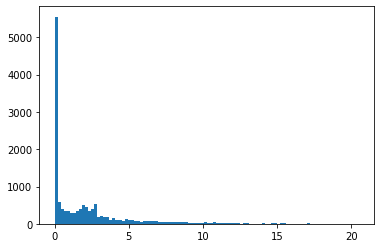

In [23]:
dataset_id = '/'.join(model.path.split('/')[-2:] + ['ML'])
with pd.HDFStore('test.h5', 'r') as s:
    df = s[dataset_id]
    df = df[df['ph'] == 8]
    print(f"Bag-of-20 FDE is {np.mean(df['fde'])}")
    plt.hist(df['fde'], bins=100)

In [13]:
batch_metrics = evaluate_full(eval_env, 8, eval_stg, hyp)

Evaluate Full (ph = 8): 100%|██████████| 60/60 [12:54<00:00, 12.91s/it]


In [19]:
len(batch_metrics['fde']), len( batch_metrics['ade'] ), len(batch_metrics['kde']),\
    len( batch_metrics['offroad_viols'] )

(28110000, 28110000, 14055, 14055)

In [20]:
dataset_id = '/'.join(model.path.split('/')[-2:] + ['Full'])

with pd.HDFStore('test.h5', 'a') as s:
    for ph in [2,4,6,8]:
        batch_metrics = evaluate_full(eval_env, ph, eval_stg, hyp)
        df = pd.DataFrame(batch_metrics)
        df['ph'] = ph
        s.put(dataset_id, df, format='t', append=True, data_columns=True)

Evaluate Full (ph = 2): 100%|██████████| 60/60 [06:18<00:00,  6.31s/it]


ValueError: arrays must all be same length

In [31]:
np.mean(batch_metrics['offroad_viols'])

0.016115384615384618

Off-road viols is 0.0486957310565635


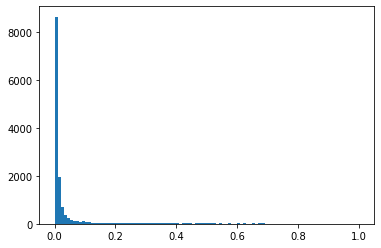

In [81]:
print(f"Off-road viols is {np.mean(offroad_viols)}")
plt.hist(offroad_viols, bins=100)
None

Getting score summaries after the fact

In [ ]:
PREDICTION_HORIZONS = [2,4,6,8]
RESULTS_FILENAMES = ['results_test20210801.h5']
scores = {}

for h5_filename in RESULTS_FILENAMES:
    with pd.HDFStore(h5_filename, 'r') as store:
        for key in store.keys():
            key_fragments = key.split('/')[1:]
            # for example
            # dataset_name v3-1-1_split1_test
            # experiment_name 20210816
            # model_name models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8
            # score_type BoN
            dataset_name, experiment_name, model_name, score_type = key_fragments
            experiment_name = f"{experiment_name}/{dataset_name}"
            if experiment_name not in scores:
                scores[experiment_name] = {}
            if model_name not in scores[experiment_name]:
                scores[experiment_name][model_name] = {}
            for ph in PREDICTION_HORIZONS:
                if ph not in scores[experiment_name][model_name]:
                    scores[experiment_name][model_name][ph] = {}
                df = store[key][store[key]['ph'] == ph]
                if score_type == 'BoN':
                    scores[experiment_name][model_name][ph]['min_ade'] = df['min_ade'].mean()
                    scores[experiment_name][model_name][ph]['min_fde'] = df['min_fde'].mean()
                elif score_type == 'ML':
                    scores[experiment_name][model_name][ph]['ade_ml'] = df['ade'].mean()
                    scores[experiment_name][model_name][ph]['fde_ml'] = df['fde'].mean()
                elif score_type == 'Full':
                    scores[experiment_name][model_name][ph]['ade'] = df['ade'].mean()
                    scores[experiment_name][model_name][ph]['fde'] = df['fde'].mean()
                elif score_type == 'Other':
                    scores[experiment_name][model_name][ph]['kde'] = df['kde'].mean()
                    scores[experiment_name][model_name][ph]['offroad_viols'] = df['offroad_viols'].mean()
                else:
                    raise Exception(f"Score type {score_type} is not recognized.")

## Off-road violations metric

Off-road violations metric: for each vehicle, for each starting timestep, get the number of predictions that went off the road.

In [75]:
predictconfig = util.AttrDict(ph=8, num_samples=2000, z_mode=False, gmm_mode=False,
        full_dist=False, all_z_sep=False, show_predictions=True)

max_hl = hyp['maximum_history_length']
with torch.no_grad():
    predictions = eval_stg.predict(scene,
            np.arange(scene.timesteps), predictconfig.ph,
            num_samples=predictconfig.num_samples,
            min_future_timesteps=predictconfig.ph,
            z_mode=predictconfig.z_mode,
            gmm_mode=predictconfig.gmm_mode,
            full_dist=predictconfig.full_dist,
            all_z_sep=predictconfig.all_z_sep)

prediction_dict, histories_dict, futures_dict = \
        prediction_output_to_trajectories(
            predictions, dt=scene.dt, max_h=max_hl, ph=predictconfig.ph, map=None)

map =  scene.map['VEHICLE']
obs_map = np.max(map.data[..., :, :, :], axis=-3)
obs_map = 1 - obs_map / 255

interp_obs_map = scipy.interpolate.RectBivariateSpline(
        range(obs_map.shape[0]),
        range(obs_map.shape[1]),
        obs_map, kx=1, ky=1)

obs_viols = []
for t in prediction_dict.keys():
    for node in prediction_dict[t].keys():
        
        # compute_road_violations()
        predicted_trajs = prediction_dict[t][node]
        old_shape = predicted_trajs.shape
        
        pred_trajs_map = map.to_map_points(predicted_trajs.reshape((-1, 2)))
        obs_map[tuple(pred_trajs_map.astype(int).T)] = 0.5
        
        traj_obs_values = interp_obs_map(pred_trajs_map[:, 0], pred_trajs_map[:, 1], grid=False)
        traj_obs_values = traj_obs_values.reshape((old_shape[0], old_shape[1], old_shape[2]))
        num_viol_trajs = np.sum(traj_obs_values.max(axis=2) > 0, dtype=float)
        obs_viols.append(num_viol_trajs)

should_plot = False
if should_plot:
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(obs_map)

(1, 2000, 8)


Count Off-road violations 84.3312693498452


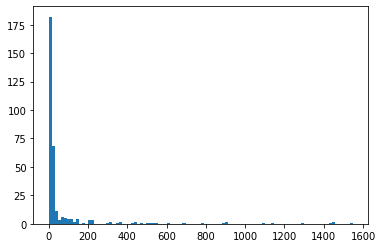

In [62]:
print(f"Count Off-road violations {np.mean(obs_viols)}")
plt.hist(obs_viols, bins=100)
None

Compute Evaluation Metrics